# Climate Tech Company Classifier

## Load Modules

In [215]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DE117240\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DE117240\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Data

In [227]:
df = pd.read_csv('../data/raw/climate_tech_companies_25042021.csv')

## Clean Data

In [228]:
#remove any without any description
df = df[df['description'].notna()]

#normalize empty/na in y class
df['domain'] = df['domain'].str.strip()
df['domain'] = df['domain'].replace(r'^\s*$', np.nan, regex=True)

#seperate those with labels and those without
data_nolabels = df[df['domain'].isna()]
data_with_labels = df[df['domain'].notna()]

print(len(data_with_labels))

313


In [232]:
df_class_groups = data_with_labels.groupby('domain').count()
df_class_groups

,name,website,city,country,subdomain,tags,ML/AI,description,logo,source
domain,,,,,,,,,,
Buildings & Cities,35,35,35,35,35,35,2,35,33,35
Climate Prediction,3,3,3,3,3,3,2,3,3,3
Collective Decisions,4,4,4,4,4,4,0,4,4,4
Education,1,1,1,1,1,1,0,1,1,1
Electricity System,78,78,76,78,78,78,11,78,72,78
Farms & Forests,31,31,31,31,31,31,3,31,26,31
Finance,11,11,11,11,11,11,0,11,11,11
Individual Action,66,66,66,66,66,66,6,66,60,66
Industry,40,40,38,40,40,40,8,40,40,40


In [239]:
# remove too small classes 
big_classes = list(df_class_groups[df_class_groups['name'] > 5].index)
data_with_labels = data_with_labels[data_with_labels['domain'].isin(big_classes)]
print(len(data_with_labels))

303


# Clean y target

In [240]:
data_with_labels['domain'] = data_with_labels['domain'].astype('category')
data_with_labels['domain_code'] = data_with_labels['domain'].cat.codes
mapping_dict = dict( enumerate(data_with_labels['domain'].cat.categories ) )
mapping_dict

{0: 'Buildings & Cities',
 1: 'Electricity System',
 2: 'Farms & Forests',
 3: 'Finance',
 4: 'Individual Action',
 5: 'Industry',
 6: 'Transportation'}

# Split Train Test

In [269]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_with_labels['description'], data_with_labels['domain_code'], test_size=0.2, random_state=1)

## Preprocessing Pipeline 

In [270]:
class TextPreprocessor():
    def __init__(self):
        pass
    
    def fit(self,X):
        X_clean = self.clean_text(X)
        return X_clean
    
    def transform(self,X):
        X_clean = self.clean_text(X)
        return X_clean
    
    def fit_transform(self,X):
        X_clean = self.transform(X)
        return X_clean

    def clean_text(self, raw_text_list):
        stop_words_list = stopwords.words('english')
        lemmatizer=WordNetLemmatizer()
        clean_text_list = raw_text_list.copy()
        clean_text_list = [str(text).lower() for text in clean_text_list]
        clean_text_list = [re.sub(r'\d+', '', text) for text in clean_text_list]
        clean_text_list = [text.translate(str.maketrans('', '', string.punctuation)) for text in clean_text_list]
        clean_text_list = [word_tokenize(text) for text in clean_text_list]
        clean_text_list = [[word for word in text if not word in stop_words_list] for text in clean_text_list]
        clean_text_list = [[lemmatizer.lemmatize(word) for word in text] for text in clean_text_list]
        clean_text_list = [" ".join(text) for text in clean_text_list]
        return clean_text_list

In [271]:
TextPreprocessor = TextPreprocessor()

In [272]:
X_train_clean = TextPreprocessor.fit_transform(X_train)
X_test_clean = TextPreprocessor.transform(X_test)

## Vectorize Pipeline

In [286]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_clean)
X_test_vectorized = vectorizer.transform(X_test_clean)

## Model Pipeline

In [287]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train_vectorized,list(y_train))
y_pred = model.predict(X_test_vectorized)

## Evaluate

In [288]:
from sklearn.metrics import classification_report

In [296]:
class_labels = mapping_dict.values()
print(classification_report(y_test, y_pred,target_names=class_labels))

                    precision    recall  f1-score   support

Buildings & Cities       1.00      0.29      0.44         7
Electricity System       0.52      0.87      0.65        15
   Farms & Forests       1.00      0.25      0.40         4
           Finance       0.00      0.00      0.00         4
 Individual Action       0.48      0.77      0.59        13
          Industry       0.67      0.50      0.57         8
    Transportation       0.83      0.50      0.62        10

          accuracy                           0.57        61
         macro avg       0.64      0.45      0.47        61
      weighted avg       0.63      0.57      0.54        61



C:\Users\DE117240\Anaconda3\envs\playground_env_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DE117240\Anaconda3\envs\playground_env_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DE117240\Anaconda3\envs\playground_env_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

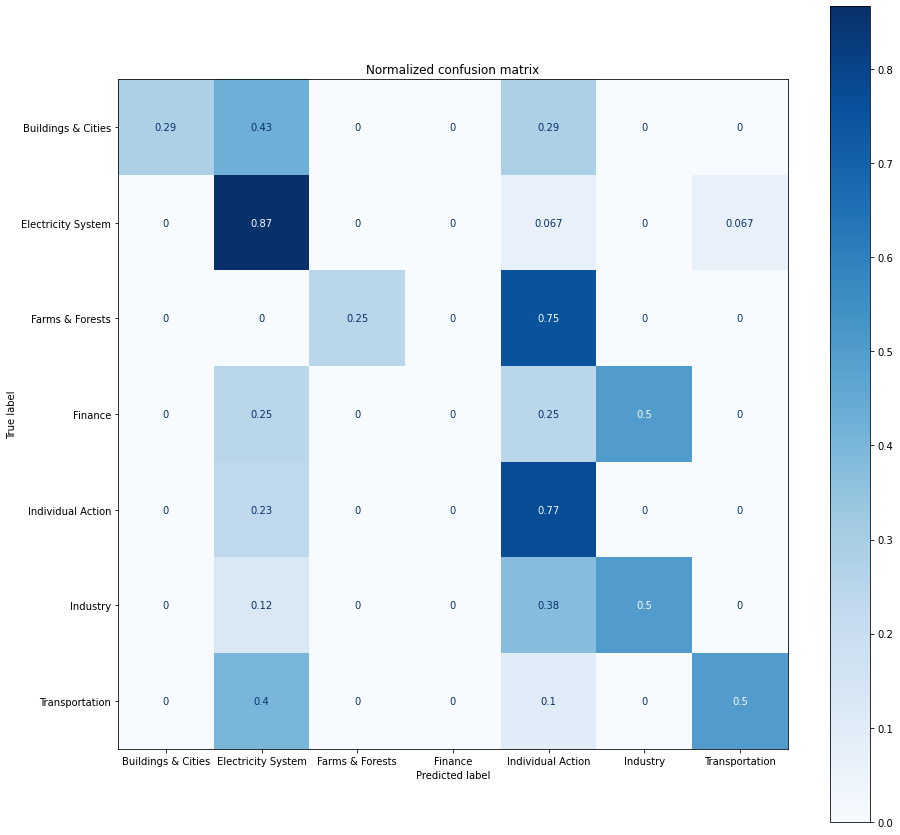

In [314]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(model, X_test_vectorized, y_test,
                             display_labels=class_labels,
                             cmap=plt.cm.Blues,
                             normalize=normalize)
disp.ax_.set_title(title)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

## Lime